# 07_progressive_unfreezing.ipynb

In [ ]:
# Investigating Progressive Unfreezing Approach
# 
# This notebook implements progressive unfreezing for transfer learning on the EuroSAT dataset.
# We start with a frozen backbone and gradually unfreeze layers from top to bottom to achieve the best trade-off between accuracy and training time.
#
# Note: notebook is a WORK IN PROGRESS

In [2]:
# Import libraries
import os
import json
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, transforms
from PIL import Image

In [3]:
# Set paths and create directories
DATASET_DIR = "../data/raw/EuroSAT_RGB"
OUTPUT_DIR = "../data/processed"
MODEL_DIR = "../models"
RESULTS_DIR = "../results"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [4]:
# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [5]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Dataset and Dataloader setup
class EuroSATDataset(Dataset):
    """
    Dataset class for EuroSAT dataset
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        # Load all image paths and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.jpg'):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [7]:
class TransformedSubset(Dataset):
    """
    Dataset wrapper that applies transforms to a subset
    """
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset)

In [8]:
# Load data splits or create them if not available
def get_data_loaders(batch_size=32, num_workers=0): # set num_workers > 0 for parallel data loading
    """
    Prepare datasets and dataloaders
    
    Args:
        batch_size: Batch size for training
        num_workers: Number of workers for data loading
        
    Returns:
        train_loader, val_loader, test_loader, class_to_idx, idx_to_class
    """
    # Define transformations
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Try loading existing splits
    splits_path = os.path.join(OUTPUT_DIR, 'dataset_splits.pt')
    
    if os.path.exists(splits_path):
        print("Loading existing dataset splits...")
        full_dataset = EuroSATDataset(DATASET_DIR, transform=None)
        class_to_idx = full_dataset.class_to_idx
        idx_to_class = {i: name for name, i in class_to_idx.items()}
        
        # Load dataset splits
        splits = torch.load(splits_path)
        train_indices = splits['train_indices']
        val_indices = splits['val_indices']
        test_indices = splits['test_indices']
        
        # Create subsets
        train_dataset = Subset(full_dataset, train_indices)
        val_dataset = Subset(full_dataset, val_indices)
        test_dataset = Subset(full_dataset, test_indices)
        
    else:
        print("Creating new dataset splits...")
        # Create full dataset
        full_dataset = EuroSATDataset(DATASET_DIR, transform=None)
        class_to_idx = full_dataset.class_to_idx
        idx_to_class = {i: name for name, i in class_to_idx.items()}
        
        # Split dataset into train, validation, and test sets
        total_size = len(full_dataset)
        train_size = int(0.7 * total_size)
        val_size = int(0.15 * total_size)
        test_size = total_size - (train_size + val_size)
        
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size, test_size], 
            generator=torch.Generator().manual_seed(SEED)
        )
        
        # Save dataset splits
        torch.save({
            'train_indices': train_dataset.indices,
            'val_indices': val_dataset.indices,
            'test_indices': test_dataset.indices,
        }, splits_path)
        
        # Save class mappings
        with open(os.path.join(OUTPUT_DIR, "class_mappings.json"), "w") as f:
            json.dump({"class_to_idx": class_to_idx, "idx_to_class": idx_to_class}, f)
    
    # Apply transformations to datasets
    train_dataset = TransformedSubset(train_dataset, train_transform)
    val_dataset = TransformedSubset(val_dataset, val_transform)
    test_dataset = TransformedSubset(test_dataset, val_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print(f"Dataset loaded with {len(train_dataset)} training, {len(val_dataset)} validation, and {len(test_dataset)} test images")
    
    return train_loader, val_loader, test_loader, class_to_idx, idx_to_class

In [9]:
# Create model with frozen backbone
def create_model(model_name='resnet18', num_classes=10):
    """
    Create a model with pretrained backbone
    
    Args:
        model_name: Name of the model to use
        num_classes: Number of output classes
        
    Returns:
        model: PyTorch model
    """
    # Load pretrained model
    if model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1')
    elif model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1')
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    elif model_name == 'efficientnet_b4':
        model = models.efficientnet_b4(weights='IMAGENET1K_V1')
    else:
        raise ValueError(f"Model {model_name} not supported")
    
    # Freeze all backbone parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the last fully connected layer
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith('efficientnet'):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    return model

In [10]:
# Function to progressively unfreeze model layers
def unfreeze_model_layers(model, model_name, unfreeze_stage=0):
    """
    Progressively unfreeze model layers from top to bottom
    
    Args:
        model: PyTorch model
        model_name: Name of the model architecture
        unfreeze_stage: Stage of unfreezing (0=only classifier, 1=last stage, 2=last two stages, etc.)
        
    Returns:
        model: Model with selected layers unfrozen
    """
    # First, freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Now unfreeze based on stages
    if model_name.startswith('resnet'):
        # ResNet layers in order from top to bottom
        if unfreeze_stage >= 0:  # Always unfreeze classifier
            for param in model.fc.parameters():
                param.requires_grad = True
            print("Unfrozen layers: fc")
            
        if unfreeze_stage >= 1:  # Last conv block
            for param in model.layer4.parameters():
                param.requires_grad = True
            print("Unfrozen layers: fc, layer4")
            
        if unfreeze_stage >= 2:  # Second last conv block
            for param in model.layer3.parameters():
                param.requires_grad = True
            print("Unfrozen layers: fc, layer4, layer3")
            
        if unfreeze_stage >= 3:  # Third last conv block
            for param in model.layer2.parameters():
                param.requires_grad = True
            print("Unfrozen layers: fc, layer4, layer3, layer2")
            
        if unfreeze_stage >= 4:  # First conv block
            for param in model.layer1.parameters():
                param.requires_grad = True
            print("Unfrozen layers: fc, layer4, layer3, layer2, layer1")
            
        if unfreeze_stage >= 5:  # Initial conv + bn
            for param in model.conv1.parameters():
                param.requires_grad = True
            for param in model.bn1.parameters():
                param.requires_grad = True
            print("Unfrozen layers: fc, layer4, layer3, layer2, layer1, conv1, bn1")
    
    elif model_name.startswith('efficientnet'):
        # Unfreeze classifier
        if unfreeze_stage >= 0:
            for param in model.classifier.parameters():
                param.requires_grad = True
            print("Unfrozen layers: classifier")
            
        # EfficientNet features is a sequential with multiple MBConv blocks
        # We unfreeze from the end towards the beginning
        if unfreeze_stage >= 1:
            num_features_blocks = len(model.features)
            blocks_per_stage = max(1, num_features_blocks // 5)  # Roughly divide into 5 stages
            
            # Unfreeze blocks from the top down based on unfreeze_stage
            for stage in range(1, min(unfreeze_stage + 1, 6)):
                start_idx = max(0, num_features_blocks - stage * blocks_per_stage)
                for i in range(start_idx, num_features_blocks):
                    for param in model.features[i].parameters():
                        param.requires_grad = True
                print(f"Unfrozen feature blocks: {start_idx}-{num_features_blocks-1}")
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.2f}%)")
    
    return model

In [11]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=5, patience=3):
    """
    Train a model with early stopping
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler (optional)
        num_epochs: Maximum number of epochs to train for
        patience: Number of epochs to wait for improvement before early stopping
        
    Returns:
        model: Trained model
        history: Training history dictionary
    """
    model = model.to(device)
    
    # Initialize training metrics
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0
    early_stopped = False
    
    # For tracking metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    # Time tracking
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            progress_bar = tqdm(dataloader, desc=f"{phase.capitalize()} Batch")
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Stats
                batch_loss = loss.item() * inputs.size(0)
                batch_corrects = torch.sum(preds == labels.data).item()
                batch_accuracy = batch_corrects / inputs.size(0)
                
                running_loss += batch_loss
                running_corrects += batch_corrects
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{batch_loss / inputs.size(0):.4f}",
                    'acc': f"{batch_accuracy:.4f}"
                })
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects / len(dataloader.dataset)
            
            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                if scheduler and scheduler.__class__.__name__ != 'ReduceLROnPlateau':
                    scheduler.step()
            else:  # val
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                
                # If scheduler is ReduceLROnPlateau, step based on validation loss
                if scheduler and scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    scheduler.step(epoch_loss)
                
                # Deep copy the model if best validation accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict().copy()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            early_stopped = True
            break
        
        print()  # Empty line between epochs
    
    # Calculate training time
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy: {best_acc:.4f}')
    
    # Add early stopping info to history
    history['early_stopped'] = early_stopped
    history['epochs_completed'] = epoch + 1
    history['best_val_acc'] = best_acc
    history['training_time'] = time_elapsed
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, best_acc

In [12]:
# Evaluation function
def evaluate_model(model, test_loader, class_names=None):
    """
    Evaluate a trained model on the test set
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test data
        class_names: List of class names
        
    Returns:
        test_acc: Test accuracy
        y_true: True labels
        y_pred: Predicted labels
    """
    model.eval()
    
    y_true = []
    y_pred = []
    test_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = (np.array(y_true) == np.array(y_pred)).mean()
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # If class names provided, create confusion matrix
    if class_names:
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Print classification report
        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    return test_acc, y_true, y_pred

In [14]:
# Plotting function for progressive unfreezing
def plot_progressive_unfreezing_results(results):
    """
    Plot training curves for progressive unfreezing
    
    Args:
        results: Results dictionary from run_progressive_unfreezing_experiment
    """
    model_name = results['model_name']
    all_histories = results['all_histories']
    stage_results = results['stage_results']
    
    # Create figure for all curves
    plt.figure(figsize=(15, 10))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(all_histories):
        # Calculate epoch offsets for consecutive plotting
        if i == 0:
            offset = 0
        else:
            offset = sum(h['epochs_completed'] for h in all_histories[:i])
        
        epochs = range(offset, offset + history['epochs_completed'])
        plt.plot(epochs, history['train_loss'], label=f'Stage {i}')
    
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation loss
    plt.subplot(2, 2, 2)
    for i, history in enumerate(all_histories):
        # Calculate epoch offsets
        if i == 0:
            offset = 0
        else:
            offset = sum(h['epochs_completed'] for h in all_histories[:i])
        
        epochs = range(offset, offset + history['epochs_completed'])
        plt.plot(epochs, history['val_loss'], label=f'Stage {i}')
    
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training accuracy
    plt.subplot(2, 2, 3)
    for i, history in enumerate(all_histories):
        # Calculate epoch offsets
        if i == 0:
            offset = 0
        else:
            offset = sum(h['epochs_completed'] for h in all_histories[:i])
        
        epochs = range(offset, offset + history['epochs_completed'])
        plt.plot(epochs, history['train_acc'], label=f'Stage {i}')
    
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(2, 2, 4)
    for i, history in enumerate(all_histories):
        # Calculate epoch offsets
        if i == 0:
            offset = 0
        else:
            offset = sum(h['epochs_completed'] for h in all_histories[:i])
        
        epochs = range(offset, offset + history['epochs_completed'])
        plt.plot(epochs, history['val_acc'], label=f'Stage {i}')
    
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"{model_name}_progressive_unfreezing.png"))
    plt.show()
    
    # Plot stage-by-stage accuracy comparison
    plt.figure(figsize=(10, 6))
    stages = list(stage_results.keys())
    
    # Extract validation accuracies for each stage
    val_accs = [stage_results[stage]['val_acc'] for stage in stages]
    best_val_accs = [stage_results[stage]['best_val_acc'] for stage in stages]
    
    # Create bar chart
    x = np.arange(len(stages))
    width = 0.35
    
    plt.bar(x - width/2, val_accs, width, label='Final Validation Accuracy')
    plt.bar(x + width/2, best_val_accs, width, label='Best Validation Accuracy')
    
    plt.xlabel('Stage')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy by Progressive Unfreezing Stage')
    plt.xticks(x, [f"Stage {i}" for i in range(len(stages))])
    plt.ylim(0.7, 1.0)  # Adjust y-axis for better visibility
    plt.legend()
    
    # Add accuracy values on top of bars
    for i, v in enumerate(val_accs):
        plt.text(i - width/2, v + 0.01, f"{v:.4f}", ha='center')
    
    for i, v in enumerate(best_val_accs):
        plt.text(i + width/2, v + 0.01, f"{v:.4f}", ha='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"{model_name}_stage_comparison.png"))
    plt.show()

In [15]:
# Save results
def save_progressive_unfreezing_results(model, results, class_to_idx):
    """
    Save model and results from progressive unfreezing experiment
    
    Args:
        model: Trained PyTorch model
        results: Results dictionary from run_progressive_unfreezing_experiment
        class_to_idx: Class to index mapping
    """
    model_name = results['model_name']
    test_accuracy = results['test_accuracy']
    
    # Create timestamp for filenames
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    
    # Save model
    model_path = os.path.join(MODEL_DIR, f"{model_name}_progressive_{timestamp}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_to_idx': class_to_idx,
        'idx_to_class': {i: name for name, i in class_to_idx.items()},
        'model_name': model_name,
        'test_accuracy': test_accuracy,
        'results': results,
        'timestamp': timestamp
    }, model_path)
    
    # Save results as JSON
    results_path = os.path.join(RESULTS_DIR, f"{model_name}_progressive_results_{timestamp}.json")
    
    # Convert NumPy arrays to lists for JSON serialization
    serializable_results = results.copy()
    
    # Process all_histories to make it JSON serializable
    for i, history in enumerate(serializable_results['all_histories']):
        for key in history:
            if isinstance(history[key], np.ndarray):
                serializable_results['all_histories'][i][key] = history[key].tolist()
            elif isinstance(history[key], (np.float32, np.float64)):
                serializable_results['all_histories'][i][key] = float(history[key])
    
    # Process stage_results to make it JSON serializable
    for stage in serializable_results['stage_results']:
        for key in serializable_results['stage_results'][stage]:
            if isinstance(serializable_results['stage_results'][stage][key], np.ndarray):
                serializable_results['stage_results'][stage][key] = serializable_results['stage_results'][stage][key].tolist()
            elif isinstance(serializable_results['stage_results'][stage][key], (np.float32, np.float64)):
                serializable_results['stage_results'][stage][key] = float(serializable_results['stage_results'][stage][key])
    
    # Save to JSON
    with open(results_path, 'w') as f:
        json.dump(serializable_results, f, indent=4)
    
    print(f"Model saved to {model_path}")
    print(f"Results saved to {results_path}")

In [13]:
# Progressive unfreezing experiment
def run_progressive_unfreezing_experiment(
    model_name='resnet18',
    batch_size=32,
    epochs_per_stage=5,
    lr_start=0.01,
    total_stages=5,
    plot_results=True
):
    """
    Run a progressive unfreezing experiment, training the model in stages
    
    Args:
        model_name: Model architecture to use
        batch_size: Batch size for training
        epochs_per_stage: Number of epochs to train for each unfreezing stage
        lr_start: Initial learning rate for stage 0 (only classifier)
        total_stages: Total number of unfreezing stages
        plot_results: Whether to plot training curves
        
    Returns:
        model: Trained model
        results: Dictionary containing results for each stage
        test_acc: Final test accuracy
    """
    # Load data
    train_loader, val_loader, test_loader, class_to_idx, idx_to_class = get_data_loaders(batch_size=batch_size)
    class_names = [idx_to_class[i] for i in range(len(class_to_idx))]
    num_classes = len(class_to_idx)
    
    # Create initial model (all frozen except classifier)
    model = create_model(model_name=model_name, num_classes=num_classes)
    
    # Track results for each stage
    stage_results = {}
    all_histories = []
    
    # Learning rate reduction for deeper layers
    lr_reduction_factor = 5  # Each stage reduces LR by this factor
    
    # Train the model stage by stage
    for stage in range(total_stages):
        print(f"\n{'='*20} Stage {stage}: Unfreezing more layers {'='*20}")
        
        # Unfreeze layers according to current stage
        model = unfreeze_model_layers(model, model_name, unfreeze_stage=stage)
        
        # Adjust learning rate based on stage
        current_lr = lr_start / (lr_reduction_factor ** stage)
        print(f"Learning rate for stage {stage}: {current_lr}")
        
        # Create optimizer - we use SGD with momentum for fine-tuning
        optimizer = optim.SGD(
            [p for p in model.parameters() if p.requires_grad], 
            lr=current_lr,
            momentum=0.9
        )
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=2, verbose=True
        )
        
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Train model for this stage
        model, history, best_val_acc = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=epochs_per_stage,
            patience=epochs_per_stage  # No early stopping within a stage
        )
        
        # Store history for this stage
        history['stage'] = stage
        all_histories.append(history)
        
        # Evaluate after this stage
        stage_val_acc = history['val_acc'][-1]
        print(f"Stage {stage} completed. Validation accuracy: {stage_val_acc:.4f}")
        
        # Store results for this stage
        stage_results[f'stage_{stage}'] = {
            'val_acc': stage_val_acc,
            'best_val_acc': best_val_acc,
            'epochs_completed': history['epochs_completed'],
            'training_time': history['training_time']
        }
    
    # Final evaluation
    print("\n{'='*20} Final Evaluation {'='*20}")
    test_acc, y_true, y_pred = evaluate_model(model, test_loader, class_names)
    
    # Store test accuracy
    results = {
        'model_name': model_name,
        'test_accuracy': test_acc,
        'stage_results': stage_results,
        'all_histories': all_histories
    }
    
    # Plot training curves
    if plot_results:
        plot_progressive_unfreezing_results(results)
    
    # Save model and results
    save_progressive_unfreezing_results(model, results, class_to_idx)
    
    return model, results, test_acc

In [16]:
# Function to compare progressive unfreezing with traditional approaches
def compare_with_traditional_approaches(model_name='resnet18', batch_size=32):
    """
    Compare progressive unfreezing with fully frozen and fully unfrozen approaches
    
    Args:
        model_name: Model architecture to use
        batch_size: Batch size for training
    """
    print("\n\n{'='*20} COMPARING TRANSFER LEARNING APPROACHES {'='*20}\n")
    
    # Load data
    train_loader, val_loader, test_loader, class_to_idx, idx_to_class = get_data_loaders(batch_size=batch_size)
    class_names = [idx_to_class[i] for i in range(len(class_to_idx))]
    num_classes = len(class_to_idx)
    
    # Approach 1: Only train classifier (fully frozen backbone)
    print("\n{'='*20} Approach 1: Frozen Backbone {'='*20}\n")
    model_frozen = create_model(model_name=model_name, num_classes=num_classes)
    optimizer_frozen = optim.Adam([p for p in model_frozen.parameters() if p.requires_grad], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    scheduler_frozen = optim.lr_scheduler.ReduceLROnPlateau(optimizer_frozen, mode='min', factor=0.1, patience=3, verbose=True)
    
    model_frozen, history_frozen, _ = train_model(
        model=model_frozen,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer_frozen,
        scheduler=scheduler_frozen,
        num_epochs=15
    )
    
    test_acc_frozen, _, _ = evaluate_model(model_frozen, test_loader)
    
    # Approach 2: Train all layers (fully unfrozen)
    print("\n{'='*20} Approach 2: Unfrozen Backbone {'='*20}\n")
    model_unfrozen = create_model(model_name=model_name, num_classes=num_classes)
    
    # Unfreeze all layers
    for param in model_unfrozen.parameters():
        param.requires_grad = True
    
    optimizer_unfrozen = optim.Adam(model_unfrozen.parameters(), lr=0.001)  # Lower learning rate for unfrozen
    scheduler_unfrozen = optim.lr_scheduler.ReduceLROnPlateau(optimizer_unfrozen, mode='min', factor=0.1, patience=3, verbose=True)
    
    model_unfrozen, history_unfrozen, _ = train_model(
        model=model_unfrozen,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer_unfrozen,
        scheduler=scheduler_unfrozen,
        num_epochs=15
    )
    
    test_acc_unfrozen, _, _ = evaluate_model(model_unfrozen, test_loader)
    
    # Approach 3: Progressive Unfreezing (run the full experiment)
    print("\n{'='*20} Approach 3: Progressive Unfreezing {'='*20}\n")
    _, results_progressive, test_acc_progressive = run_progressive_unfreezing_experiment(
        model_name=model_name,
        batch_size=batch_size,
        epochs_per_stage=3,  # Fewer epochs per stage for quicker comparison
        total_stages=5,
        plot_results=False  # We'll create our own comparison plot
    )
    
    # Compare results
    approaches = ["Frozen Backbone", "Unfrozen Backbone", "Progressive Unfreezing"]
    accuracies = [test_acc_frozen, test_acc_unfrozen, test_acc_progressive]
    training_time_frozen = history_frozen['training_time']
    training_time_unfrozen = history_unfrozen['training_time']
    training_time_progressive = sum(results_progressive['stage_results'][s]['training_time'] for s in results_progressive['stage_results'])
    
    training_times = [training_time_frozen, training_time_unfrozen, training_time_progressive]
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot test accuracies
    ax1.bar(approaches, accuracies, color=['blue', 'green', 'red'])
    ax1.set_ylabel('Test Accuracy')
    ax1.set_title('Test Accuracy Comparison')
    ax1.set_ylim(0.8, 1.0)  # Adjust based on your expected accuracy range
    
    # Add accuracy values on top of bars
    for i, v in enumerate(accuracies):
        ax1.text(i, v + 0.01, f"{v:.4f}", ha='center')
    
    # Plot training times
    ax2.bar(approaches, [t/60 for t in training_times], color=['blue', 'green', 'red'])
    ax2.set_ylabel('Training Time (minutes)')
    ax2.set_title('Training Time Comparison')
    
    # Add training time values on top of bars
    for i, v in enumerate(training_times):
        ax2.text(i, v/60 + 1, f"{v/60:.1f}", ha='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"{model_name}_approach_comparison.png"))
    plt.show()
    
    # Create a summary table
    summary = {
        'Approach': approaches,
        'Test Accuracy': [f"{acc:.4f}" for acc in accuracies],
        'Training Time (min)': [f"{t/60:.1f}" for t in training_times],
        'Accuracy/Time Ratio': [f"{acc/(t/60):.4f}" for acc, t in zip(accuracies, training_times)]
    }
    
    # Print summary table
    print("\n{'='*20} SUMMARY {'='*20}")
    print(f"{'Approach':<25} {'Test Accuracy':<15} {'Training Time (min)':<20} {'Efficiency Ratio':<20}")
    print('-' * 80)
    for i in range(len(approaches)):
        print(f"{summary['Approach'][i]:<25} {summary['Test Accuracy'][i]:<15} {summary['Training Time (min)'][i]:<20} {summary['Accuracy/Time Ratio'][i]:<20}")

Loading existing dataset splits...
Dataset loaded with 18900 training, 4050 validation, and 4050 test images

==================== Stage 0: Unfreezing more layers ====================
Unfrozen layers: fc
Trainable parameters: 5,130 / 11,181,642 (0.05%)
Learning rate for stage 0: 0.01
Epoch 1/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.2369 Acc: 0.6796


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.9064 Acc: 0.7654

Epoch 2/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.2083 Acc: 0.7183


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.6349 Acc: 0.6331

Epoch 3/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.2032 Acc: 0.7229


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.1711 Acc: 0.6983

Epoch 4/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.2279 Acc: 0.7194


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.0909 Acc: 0.7590

Epoch 5/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.9609 Acc: 0.7549


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.7687 Acc: 0.8002

Training complete in 6m 17s
Best validation accuracy: 0.8002
Stage 0 completed. Validation accuracy: 0.8002

==================== Stage 1: Unfreezing more layers ====================
Unfrozen layers: fc
Unfrozen layers: fc, layer4
Trainable parameters: 8,398,858 / 11,181,642 (75.11%)
Learning rate for stage 1: 0.002
Epoch 1/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.7049 Acc: 0.8162


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3833 Acc: 0.8625

Epoch 2/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.3493 Acc: 0.8875


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2323 Acc: 0.9198

Epoch 3/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2947 Acc: 0.8980


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2235 Acc: 0.9240

Epoch 4/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2576 Acc: 0.9142


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1927 Acc: 0.9368

Epoch 5/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2545 Acc: 0.9133


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1795 Acc: 0.9375

Training complete in 14m 3s
Best validation accuracy: 0.9375
Stage 1 completed. Validation accuracy: 0.9375

==================== Stage 2: Unfreezing more layers ====================
Unfrozen layers: fc
Unfrozen layers: fc, layer4
Unfrozen layers: fc, layer4, layer3
Trainable parameters: 10,498,570 / 11,181,642 (93.89%)
Learning rate for stage 2: 0.0004
Epoch 1/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1998 Acc: 0.9311


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1503 Acc: 0.9481

Epoch 2/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1787 Acc: 0.9362


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1406 Acc: 0.9506

Epoch 3/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1709 Acc: 0.9413


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1383 Acc: 0.9514

Epoch 4/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1549 Acc: 0.9453


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1324 Acc: 0.9536

Epoch 5/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1430 Acc: 0.9501


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1349 Acc: 0.9541

Training complete in 15m 16s
Best validation accuracy: 0.9541
Stage 2 completed. Validation accuracy: 0.9541

==================== Stage 3: Unfreezing more layers ====================
Unfrozen layers: fc
Unfrozen layers: fc, layer4
Unfrozen layers: fc, layer4, layer3
Unfrozen layers: fc, layer4, layer3, layer2
Trainable parameters: 11,024,138 / 11,181,642 (98.59%)
Learning rate for stage 3: 8e-05
Epoch 1/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1415 Acc: 0.9496


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1267 Acc: 0.9563

Epoch 2/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1414 Acc: 0.9502


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1222 Acc: 0.9565

Epoch 3/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1303 Acc: 0.9551


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1191 Acc: 0.9588

Epoch 4/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1296 Acc: 0.9565


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1193 Acc: 0.9568

Epoch 5/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1203 Acc: 0.9596


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1181 Acc: 0.9590

Training complete in 18m 1s
Best validation accuracy: 0.9590
Stage 3 completed. Validation accuracy: 0.9590

==================== Stage 4: Unfreezing more layers ====================
Unfrozen layers: fc
Unfrozen layers: fc, layer4
Unfrozen layers: fc, layer4, layer3
Unfrozen layers: fc, layer4, layer3, layer2
Unfrozen layers: fc, layer4, layer3, layer2, layer1
Trainable parameters: 11,172,106 / 11,181,642 (99.91%)
Learning rate for stage 4: 1.6e-05
Epoch 1/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1267 Acc: 0.9558


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1160 Acc: 0.9598

Epoch 2/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1228 Acc: 0.9561


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1135 Acc: 0.9607

Epoch 3/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1166 Acc: 0.9587


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1145 Acc: 0.9612

Epoch 4/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1185 Acc: 0.9593


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1153 Acc: 0.9590

Epoch 5/5
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1188 Acc: 0.9578


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1170 Acc: 0.9588

Training complete in 18m 7s
Best validation accuracy: 0.9612
Stage 4 completed. Validation accuracy: 0.9588

{'='*20} Final Evaluation {'='*20}


Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Test Loss: 0.1193
Test Accuracy: 0.9568


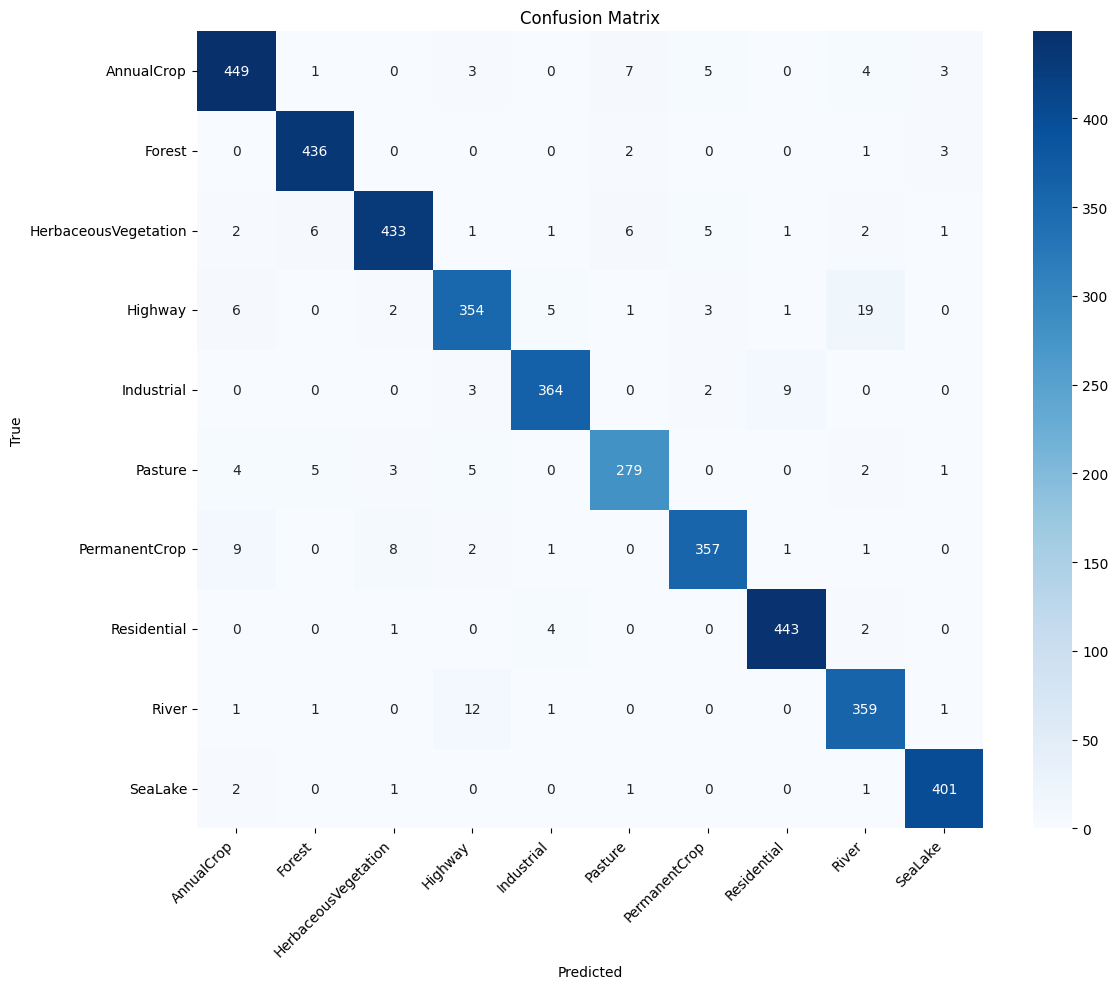

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.9493    0.9513    0.9503       472
              Forest     0.9710    0.9864    0.9787       442
HerbaceousVegetation     0.9665    0.9454    0.9558       458
             Highway     0.9316    0.9054    0.9183       391
          Industrial     0.9681    0.9630    0.9655       378
             Pasture     0.9426    0.9331    0.9378       299
       PermanentCrop     0.9597    0.9420    0.9507       379
         Residential     0.9736    0.9844    0.9790       450
               River     0.9182    0.9573    0.9373       375
             SeaLake     0.9780    0.9877    0.9828       406

            accuracy                         0.9568      4050
           macro avg     0.9559    0.9556    0.9556      4050
        weighted avg     0.9568    0.9568    0.9567      4050



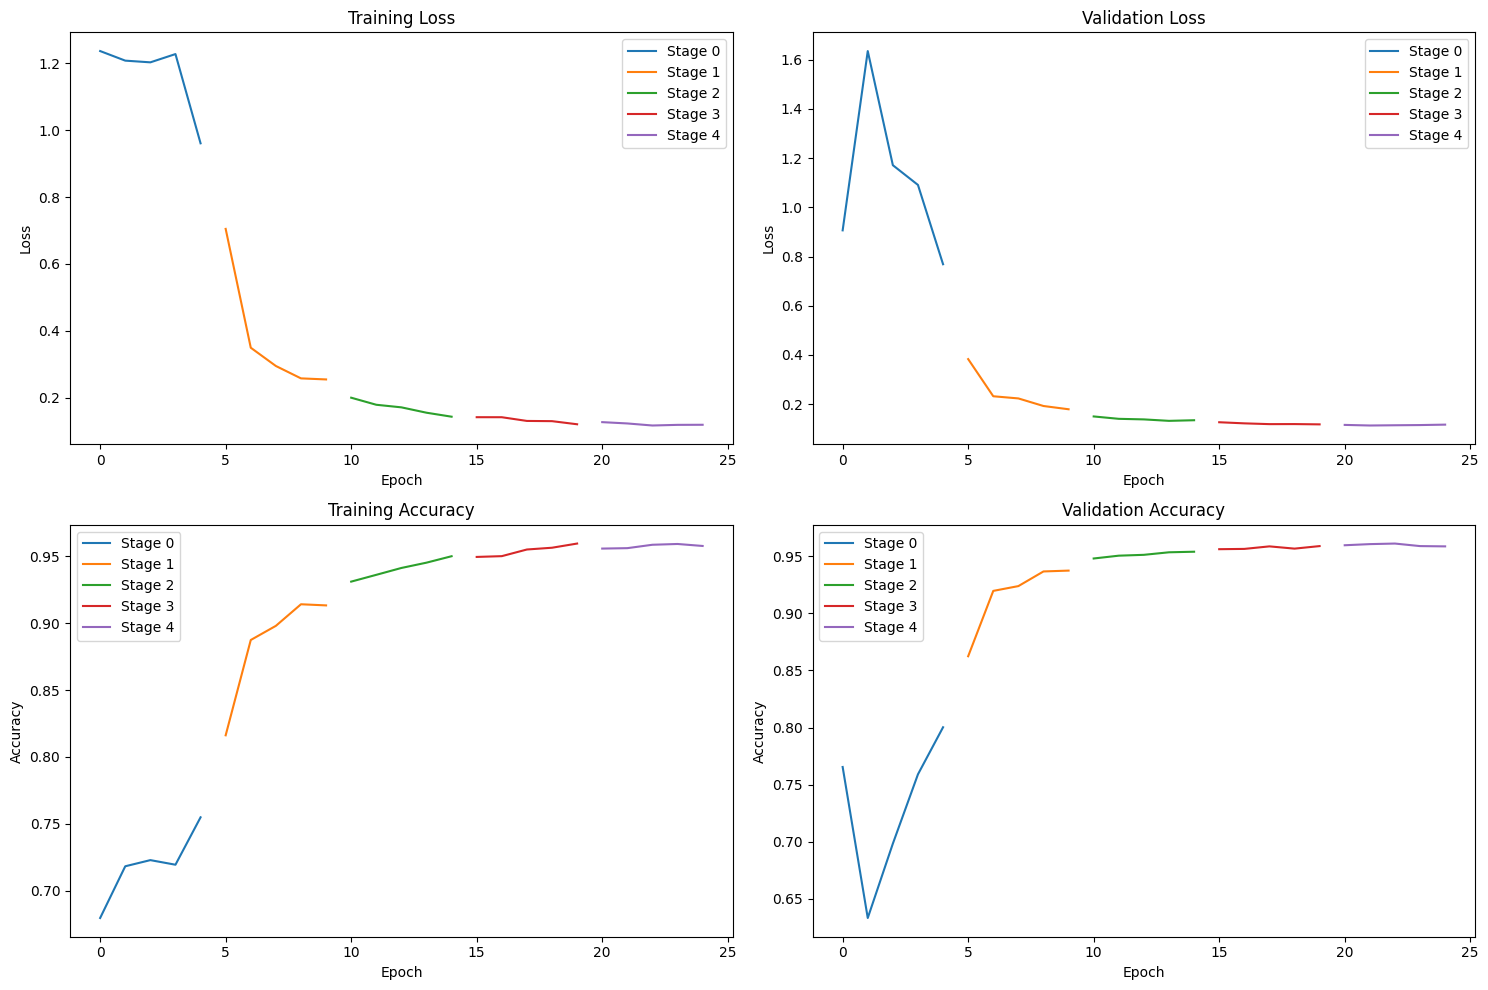

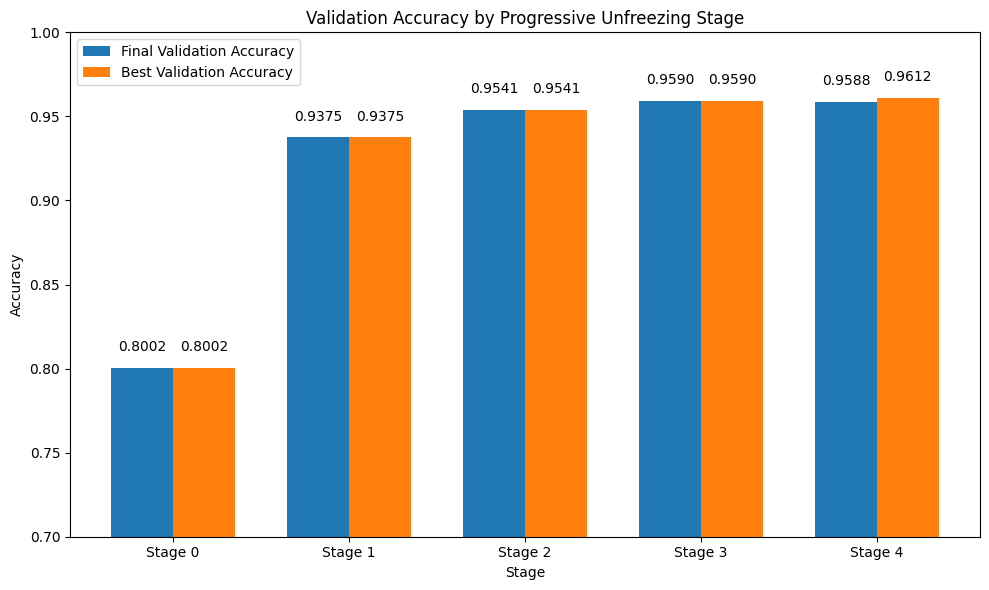

Model saved to ../models\resnet18_progressive_20250407_1420.pth
Results saved to ../results\resnet18_progressive_results_20250407_1420.json
Final test accuracy: 0.9568


{'='*20} COMPARING TRANSFER LEARNING APPROACHES {'='*20}

Loading existing dataset splits...
Dataset loaded with 18900 training, 4050 validation, and 4050 test images

{'='*20} Approach 1: Frozen Backbone {'='*20}

Epoch 1/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.3482 Acc: 0.6710


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.9851 Acc: 0.7622

Epoch 2/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.5398 Acc: 0.6925


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.2504 Acc: 0.7427

Epoch 3/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.5200 Acc: 0.7093


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.6090 Acc: 0.7284

Epoch 4/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.5653 Acc: 0.7081


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.4116 Acc: 0.7180
Early stopping triggered after 4 epochs
Training complete in 5m 40s
Best validation accuracy: 0.7622


Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Test Loss: 1.3238
Test Accuracy: 0.7341

{'='*20} Approach 2: Unfrozen Backbone {'='*20}

Epoch 1/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.6090 Acc: 0.8070


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.4966 Acc: 0.8370

Epoch 2/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.3938 Acc: 0.8733


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3275 Acc: 0.8906

Epoch 3/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.3073 Acc: 0.8981


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2025 Acc: 0.9356

Epoch 4/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2933 Acc: 0.9043


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1814 Acc: 0.9375

Epoch 5/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2686 Acc: 0.9135


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.3596 Acc: 0.8958

Epoch 6/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2550 Acc: 0.9178


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1714 Acc: 0.9442

Epoch 7/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2256 Acc: 0.9260


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2129 Acc: 0.9279

Epoch 8/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2112 Acc: 0.9302


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1805 Acc: 0.9415

Epoch 9/15
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1959 Acc: 0.9339


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2190 Acc: 0.9272
Early stopping triggered after 9 epochs
Training complete in 42m 35s
Best validation accuracy: 0.9442


Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Test Loss: 0.2399
Test Accuracy: 0.9264

{'='*20} Approach 3: Progressive Unfreezing {'='*20}

Loading existing dataset splits...
Dataset loaded with 18900 training, 4050 validation, and 4050 test images

==================== Stage 0: Unfreezing more layers ====================
Unfrozen layers: fc
Trainable parameters: 5,130 / 11,181,642 (0.05%)
Learning rate for stage 0: 0.01
Epoch 1/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.2398 Acc: 0.6774


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.9524 Acc: 0.7637

Epoch 2/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.1956 Acc: 0.7163


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.0251 Acc: 0.7501

Epoch 3/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 1.1994 Acc: 0.7198


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 1.0199 Acc: 0.7568

Training complete in 4m 7s
Best validation accuracy: 0.7637
Stage 0 completed. Validation accuracy: 0.7568

==================== Stage 1: Unfreezing more layers ====================
Unfrozen layers: fc
Unfrozen layers: fc, layer4
Trainable parameters: 8,398,858 / 11,181,642 (75.11%)
Learning rate for stage 1: 0.002
Epoch 1/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.6661 Acc: 0.8181


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2528 Acc: 0.9156

Epoch 2/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.3437 Acc: 0.8833


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2548 Acc: 0.9178

Epoch 3/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2991 Acc: 0.8972


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.2014 Acc: 0.9274

Training complete in 8m 52s
Best validation accuracy: 0.9274
Stage 1 completed. Validation accuracy: 0.9274

==================== Stage 2: Unfreezing more layers ====================
Unfrozen layers: fc
Unfrozen layers: fc, layer4
Unfrozen layers: fc, layer4, layer3
Trainable parameters: 10,498,570 / 11,181,642 (93.89%)
Learning rate for stage 2: 0.0004
Epoch 1/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2331 Acc: 0.9176


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1664 Acc: 0.9420

Epoch 2/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.2043 Acc: 0.9282


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1509 Acc: 0.9481

Epoch 3/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1899 Acc: 0.9324


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1431 Acc: 0.9489

Training complete in 9m 45s
Best validation accuracy: 0.9489
Stage 2 completed. Validation accuracy: 0.9489

==================== Stage 3: Unfreezing more layers ====================
Unfrozen layers: fc
Unfrozen layers: fc, layer4
Unfrozen layers: fc, layer4, layer3
Unfrozen layers: fc, layer4, layer3, layer2
Trainable parameters: 11,024,138 / 11,181,642 (98.59%)
Learning rate for stage 3: 8e-05
Epoch 1/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1821 Acc: 0.9357


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1362 Acc: 0.9533

Epoch 2/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1730 Acc: 0.9403


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1329 Acc: 0.9565

Epoch 3/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1605 Acc: 0.9436


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1287 Acc: 0.9565

Training complete in 11m 13s
Best validation accuracy: 0.9565
Stage 3 completed. Validation accuracy: 0.9565

==================== Stage 4: Unfreezing more layers ====================
Unfrozen layers: fc
Unfrozen layers: fc, layer4
Unfrozen layers: fc, layer4, layer3
Unfrozen layers: fc, layer4, layer3, layer2
Unfrozen layers: fc, layer4, layer3, layer2, layer1
Trainable parameters: 11,172,106 / 11,181,642 (99.91%)
Learning rate for stage 4: 1.6e-05
Epoch 1/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1564 Acc: 0.9442


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1288 Acc: 0.9568

Epoch 2/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1563 Acc: 0.9458


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1295 Acc: 0.9556

Epoch 3/3
----------


Train Batch:   0%|          | 0/591 [00:00<?, ?it/s]

train Loss: 0.1606 Acc: 0.9438


Val Batch:   0%|          | 0/127 [00:00<?, ?it/s]

val Loss: 0.1253 Acc: 0.9580

Training complete in 11m 19s
Best validation accuracy: 0.9580
Stage 4 completed. Validation accuracy: 0.9580

{'='*20} Final Evaluation {'='*20}


Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Test Loss: 0.1314
Test Accuracy: 0.9516


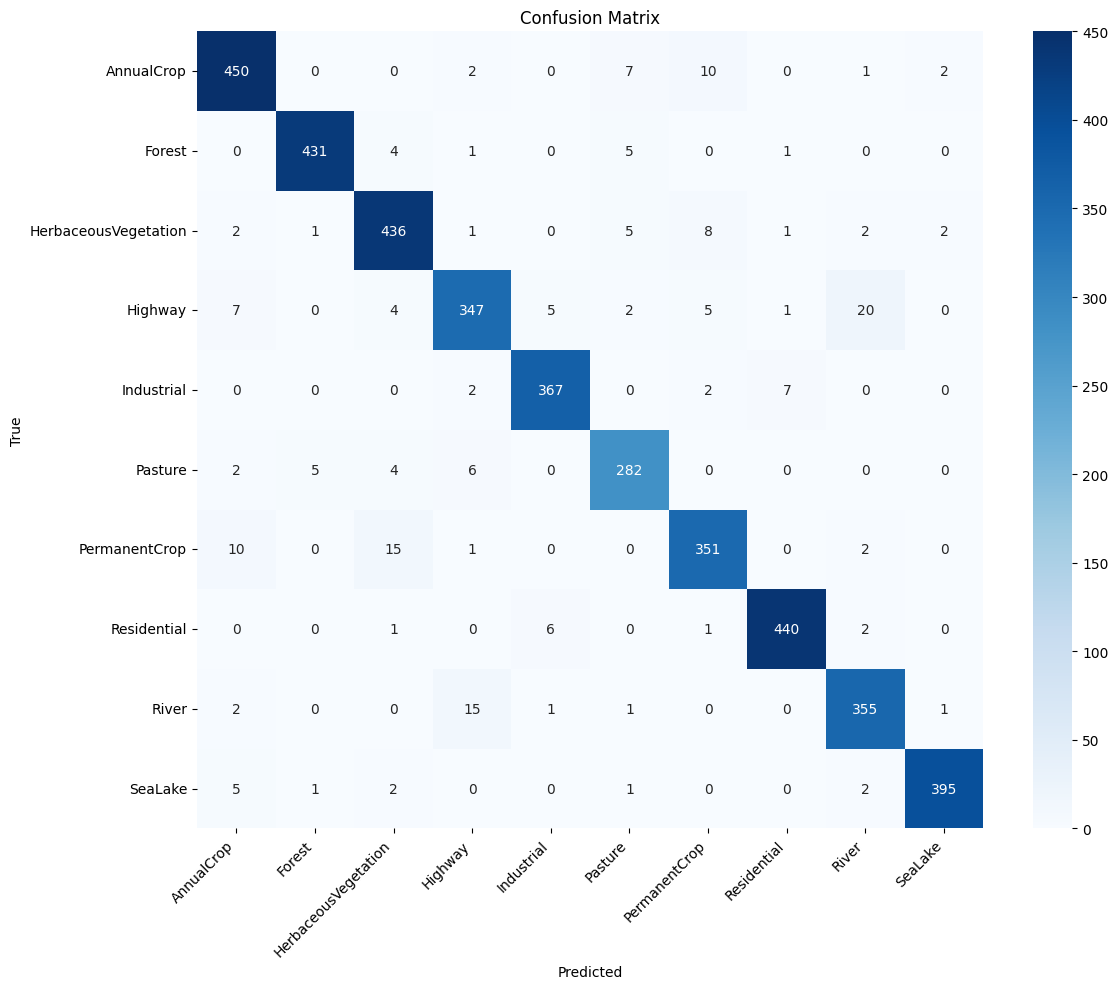

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.9414    0.9534    0.9474       472
              Forest     0.9840    0.9751    0.9795       442
HerbaceousVegetation     0.9356    0.9520    0.9437       458
             Highway     0.9253    0.8875    0.9060       391
          Industrial     0.9683    0.9709    0.9696       378
             Pasture     0.9307    0.9431    0.9369       299
       PermanentCrop     0.9310    0.9261    0.9286       379
         Residential     0.9778    0.9778    0.9778       450
               River     0.9245    0.9467    0.9354       375
             SeaLake     0.9875    0.9729    0.9801       406

            accuracy                         0.9516      4050
           macro avg     0.9506    0.9505    0.9505      4050
        weighted avg     0.9517    0.9516    0.9516      4050

Model saved to ../models\resnet18_progressive_20250407_1554.pth
Results saved to ../results\resnet18_progr

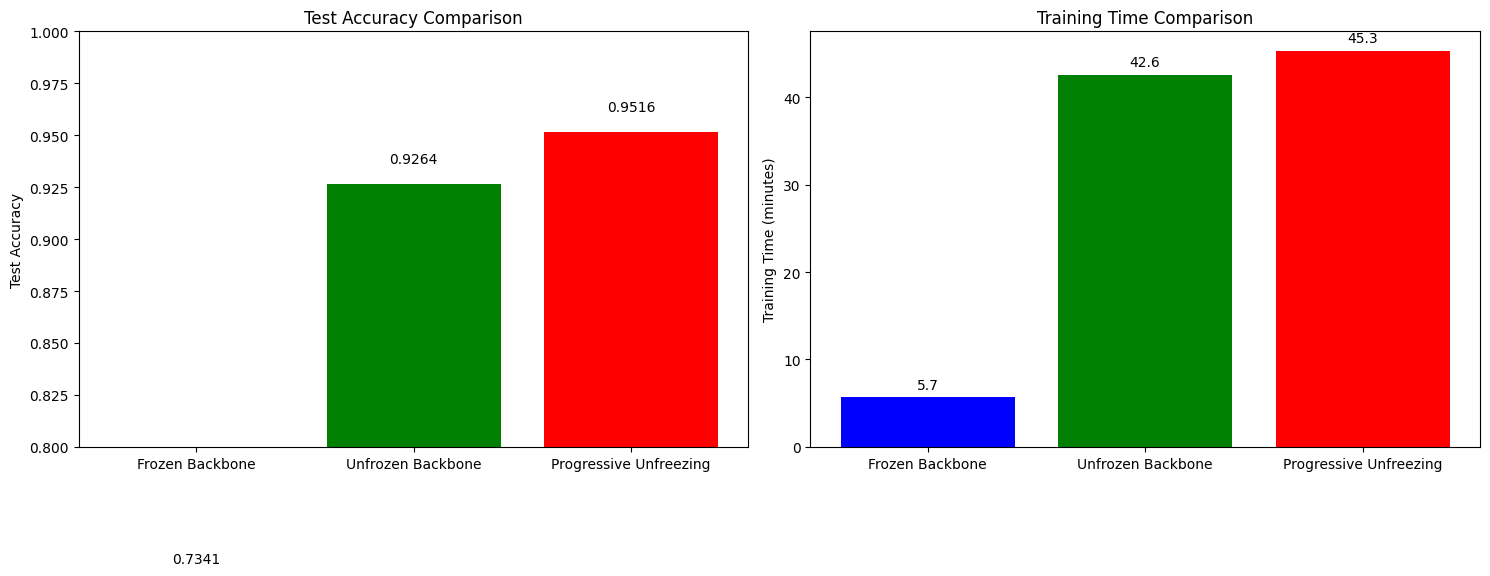


{'='*20} SUMMARY {'='*20}
Approach                  Test Accuracy   Training Time (min)  Efficiency Ratio    
--------------------------------------------------------------------------------
Frozen Backbone           0.7341          5.7                  0.1296              
Unfrozen Backbone         0.9264          42.6                 0.0218              
Progressive Unfreezing    0.9516          45.3                 0.0210              


In [17]:
# Main execution block
if __name__ == "__main__":
    # Configuration
    model_name = 'resnet18'  # Options: 'resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b4'
    batch_size = 32
    
    # Choose experiment to run
    experiment_type = "both"  # Options: "progressive", "compare", "both"
    
    if experiment_type == "progressive" or experiment_type == "both":
        # Run progressive unfreezing experiment
        model, results, test_acc = run_progressive_unfreezing_experiment(
            model_name=model_name,
            batch_size=batch_size,
            epochs_per_stage=5,
            lr_start=0.01,
            total_stages=5
        )
        
        print(f"Final test accuracy: {test_acc:.4f}")
    
    if experiment_type == "compare" or experiment_type == "both":
        # Run comparison between approaches
        compare_with_traditional_approaches(
            model_name=model_name,
            batch_size=batch_size)